In [46]:
import mysql.connector
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity

In [50]:
#Open DB Connection
db_writer = mysql.connector.connect(
   host="104.154.187.13",
    database="masters",
    user="root",
    passwd="smu")

#Set and clean the input sentence
sent = "you really hit one out of the park."
sent = sent.strip().lower().replace('(', '').replace(')', '')
corpus = [] 
corpus.append(sent)

#Query the DB Sentences
query = "select text from Sentences where language_key='EN'"
cursor = db_writer.cursor()
cursor.execute(query)
row = cursor.fetchone() 

#Clean the DB Sentences
while row is not None:
    row = row[0].strip().lower().replace('(', '').replace(')', '')
    corpus.append(row)
    row = cursor.fetchone()
    
cursor.close()
db_writer.close()

#Vectorize the sentences
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
print (tfidf_matrix.shape)

(201, 316)


### Cosine Similarity and Euclidean Distances

In [51]:
#Find and print Euclidean Distances
e_distance = []
e_distance.append(euclidean_distances(tfidf_matrix[0:1], tfidf_matrix[1:]))

print("Least Distance: " + str(np.min(e_distance)))
print("Bottom 2 Distances: " + str(np.sort(e_distance, axis=None)[0:2]))
percent_diff = round(((np.sort(e_distance, axis=None)[1]/np.sort(e_distance, axis=None)[0])-1)*100,2)
print("Difference between top 2 guesses: " + str(percent_diff) + "%")
index_min = np.argmin(e_distance)
print("Index of Least Distance: " + str(index_min))
print("Best Euclidean Match: '" + corpus[index_min+1] +"'")

Least Distance: 0.419937521889
Bottom 2 Distances: [ 0.41993752  1.22477561]
Difference between top 2 guesses: 191.66%
Index of Least Distance: 69
Best Euclidean Match: 'you hit one out of the park'


In [52]:
c_similarity = []
c_similarity.append(cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]))

print("Highest Similarity: " + str(np.max(c_similarity)))
print("Top 2 Similarities: " + str(np.sort(c_similarity, axis=None)[::-1][0:2]))
percent_diff = round(((np.sort(c_similarity, axis=None)[::-1][0]/np.sort(c_similarity, axis=None)[::-1][1])-1)*100,2)
print("Difference between top 2 guesses: " + str(percent_diff) + "%")
index_max = np.argmax(c_similarity)
print("Index of Highest Similarity: " + str(index_max))
print("Best Cosine Similarity Match: '" + corpus[index_max+1] +"'")

Highest Similarity: 0.911826238855
Top 2 Similarities: [ 0.91182624  0.24996236]
Difference between top 2 guesses: 264.79%
Index of Highest Similarity: 69
Best Cosine Similarity Match: 'you hit one out of the park'


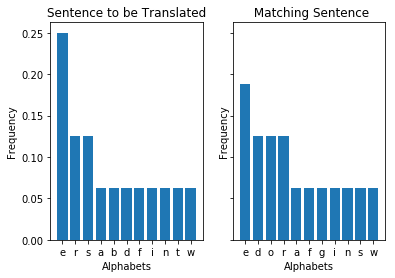

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

test = sent
sentence = corpus[index_max+1]

# convert input to list of chars so it is easy to get into pandas 
char_list1 = list(test)
char_list2 = list(sentence)

# create a dataframe where each char is one row
df1 = pd.DataFrame({'chars': char_list1})
df2 = pd.DataFrame({'chars': char_list2})

# drop all the space characters
df1 = df1[df1.chars != ' ']
df2 = df2[df2.chars != ' ']

# add a column for aggregation later
df1['num'] = 1
df2['num'] = 1
# group rows by character type, count the occurences in each group
# and sort by occurance
df1 = df1.groupby('chars').sum().sort_values('num', ascending=False) / len(df1)
df2 = df2.groupby('chars').sum().sort_values('num', ascending=False) / len(df2)

# df1 = df1.groupby('chars').sum() / len(df1)
# df2 = df2.groupby('chars').sum() / len(df2)


#plt.bar(df.index, df.num, width=0.5, color='g')
bar_width = 0.35
 
# z = str(df2.index+bar_width)

# fig, ax = plt.subplots()
# ip = ax.bar(df1.index, df1.num, bar_width,
#                 label="Input")



# from_db = ax.bar(z, df2.num,
#                  bar_width, label="DB Sentence")

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

pos1 = np.arange(len(df1.num))
ax1.bar(pos1,df1.num)
plt.sca(ax1)
plt.xticks(pos1,df1.index)

pos2 = np.arange(len(df2.num))
ax2.bar(pos2,df2.num)
plt.sca(ax2)
plt.xticks(pos2,df2.index)

ax1.set_xlabel('Alphabets')
ax1.set_ylabel('Frequency')
ax1.set_title('Sentence to be Translated')

ax2.set_xlabel('Alphabets')
ax2.set_ylabel('Frequency')
ax2.set_title(' Matching Sentence')

plt.show()